In [10]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import math

from scipy import signal
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel

from matplotlib import rc

#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Functions for reading in waveforms, and ramp function for tapering

In [18]:
def ReadExtrapolatedMode(file, mode = (2,2), order = 2, mass = 68 * const.M_sun, distance = 400000 * const.kpc, dt=1/2048):
    """ Read in an extrapolated SXS-format gravitational waveform mode, and 
        output the waveform in astrophysical units"""

    l = mode[0]
    m = mode[1]
    f = h5py.File(file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    time = time - time[0]
    
    re_adj = re*const.G*mass/((const.c)**2*distance)
    im_adj = im*const.G*mass/((const.c)**2*distance)
    time_adj = time*mass*const.G/(const.c**3)
    
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_r = CubicSpline(time_adj,re_adj)
    cs_i = CubicSpline(time_adj,im_adj)
    
    real = cs_r(times)
    imag = cs_i(times)
    
    return times, real, imag, dt

def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1
    

## Generate the frames files

In [19]:
def GenerateFrames(rh_dir, mass, distance, t_gps = 1126259462.4107006, peak_time_in_segment = 8.0, 
                   segment_length = 16.0, sample_rate = 2048, ra = 4.7614763656, 
                   dec=-0.531780006467, pol=0.310886773011):
    """ mass is the total mass of the system in solar masses
        distance is the distance to the system in megaparsecs """
    
    ## Read in the data
    rh_file = rh_dir + "/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
    t, re, img, dt = ReadExtrapolatedMode(rh_file, mode = (2,2), order = 2,  \
                                          mass = mass * const.M_sun, distance = distance * 1000 * const.kpc)
    
    ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])
    
    re = re * ramp
    img = img * ramp
    
    h_plus = re + img
    h_cross = re - img
    
    ## shift and pad the waveform before we do anything else
    
    t_peak = t[np.argmax(h_plus**2 + h_cross**2)]

    ## Parameters for shifting and padding the data
    shift_amount = (peak_time_in_segment - t_peak)
    start_pad = int(shift_amount * 2048)
    end_pad = int(sample_rate*segment_length - len(h_plus) - start_pad)
    segment_start = math.floor(t_gps) - int(peak_time_in_segment)

    h_plus = np.pad(h_plus, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    h_cross = np.pad(h_cross, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
    t = np.arange(0., segment_length, dt) + t_gps - peak_time_in_segment
    
    strainH, strainL, timeH, timeL = ProjectToDetectors(ra=ra, dec=dec, pol=pol, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=t)
    
    H1_padded = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1_padded = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    H1_padded.write(rh_dir + "/H-H1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf")
    L1_padded.write(rh_dir + "/L-L1_HOFT-" + str(segment_start) + \
                    "-" + str(int(segment_length)) + ".gwf")

In [20]:
#GenerateFrames("/home/maria.okounkova/BeyondGRAnalysis/WaveformsSimpler/dCS_0p0_Lev2", 68, 10)
GenerateFrames("/home/maria.okounkova/BeyondGRAnalysis/SXSWaveform0305", 68, 400)

0.005239059443450027


## Read in TimeSeries from frames file and plot

In [21]:
def PlotSeriesFromFile(file, plot_fft = False):
    """ """

    s1 = TimeSeries.read(source = file, channel="H1:LDAS_STRAIN")
    t1 = s1.times
    t_peak = t1[np.argmax(np.absolute(s1))]
    print("t_peak = ",t_peak)

    plt.figure(figsize=(10, 8))
    
    if plot_fft:
        fft = s1.fft()
        plt.plot(fft.frequencies, np.abs(fft.value))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('h')
        plt.xlim(0, 400)
        plt.yscale('log')
        plt.axvline(25, color='black', label='25 Hz')
        plt.legend()
        plt.ylim(1e-25, 2e-21)
    
    else:
        plt.plot(t1, s1, label='H1', color='orange')
        plt.xlabel('Time [sec]')
        plt.legend()
        plt.ylabel('h')
        
    plt.show()
    

t_peak =  1126259462.4111888 s


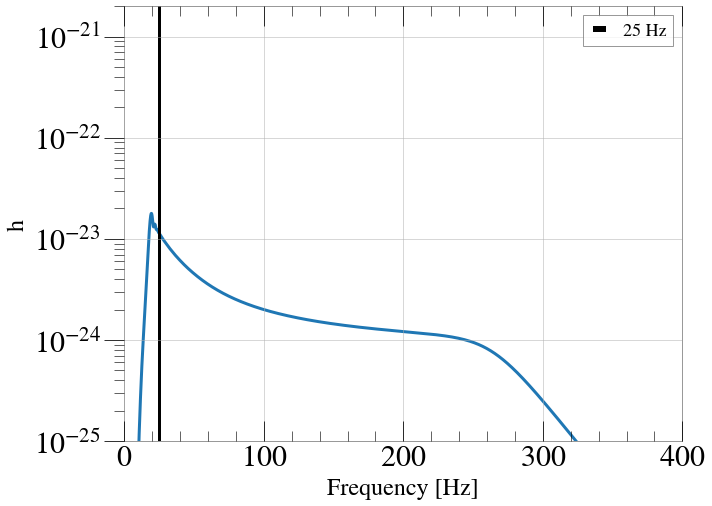

In [22]:
PlotSeriesFromFile("/home/maria.okounkova/BeyondGRAnalysis/SXSWaveform0305/H-H1_HOFT-1126259454-16.gwf", plot_fft = True)